# Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import networkx as nx
import random
from cdlib import algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'graph_tool', 'wurlitzer', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


# general da code for clustering

In [2]:
# a = [[3.00168942, 1.69384934],
#  [3.00168942, 1.69384934],
#  [3.00168942, 1.69384934],
#  [3.00168942, 1.69384934],
#  [3.00168942, 1.69384934],
#  [3.00168942, 1.69384934],
#  [3.00168942, 1.69384934],
#  [3.00168942, 1.69384934],
#  [3.00168942, 1.69384934]]

# unique_rows = np.unique(a, axis=0)
# print("Unique rows:\n", unique_rows)
# print("Number of unique rows:", unique_rows.shape[0])

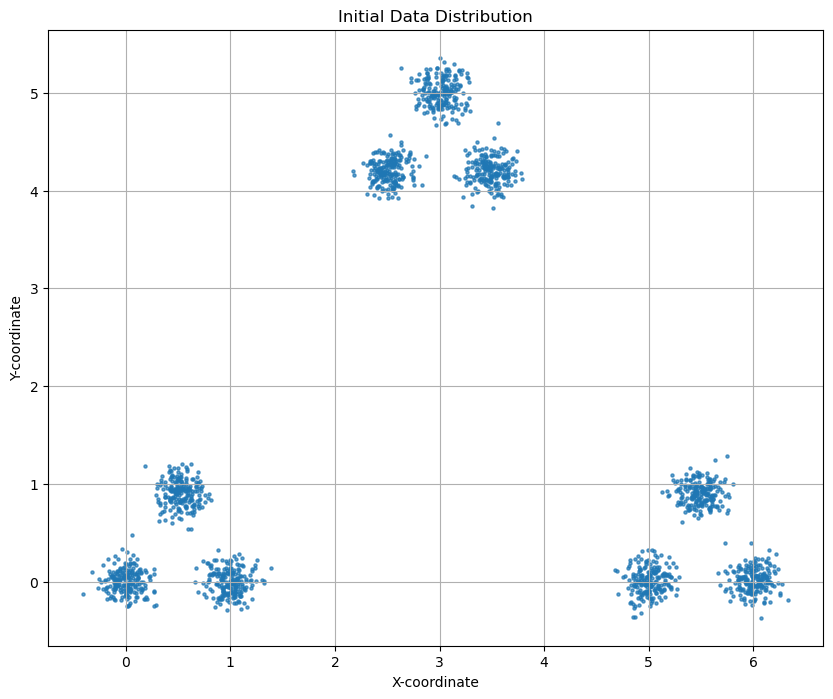

-------
[[0.00055556 0.00055556 0.00055556 ... 0.00055556 0.00055556 0.00055556]]
[[ 0.06208927 -0.01728304]
 [ 0.08096107  0.19037873]
 [-0.02926917 -0.02926712]
 ...
 [ 3.15740415  5.14330511]
 [ 2.87832765  5.12589167]
 [ 3.04201812  4.97156547]]
[[3.00168942 1.69384934]]
-------
[[3.00168942 1.69384934]
 [3.00168942 1.69384934]
 [3.00168942 1.69384934]
 [3.00168942 1.69384934]
 [3.00168942 1.69384934]
 [3.00168942 1.69384934]
 [3.00168942 1.69384934]
 [3.00168942 1.69384934]
 [3.00168942 1.69384934]]
Temperature 80
Loss [[-167.41730009]]
Loss [[-167.41728207]]
Loss [[-167.4172855]]
Temperature 79.2
Loss [[-165.65950168]]
Loss [[-165.65950063]]
Temperature 78.408
Loss [[-163.91929948]]
Loss [[-163.91929837]]
Temperature 77.62392
Loss [[-162.19650205]]
Loss [[-162.19650282]]
Temperature 76.84768079999999
Loss [[-160.49093126]]
Loss [[-160.49093482]]
Temperature 76.07920399199999
Loss [[-158.80241165]]
Loss [[-158.8024188]]
Temperature 75.31841195207998
Loss [[-157.1307863]]
Loss [[-1

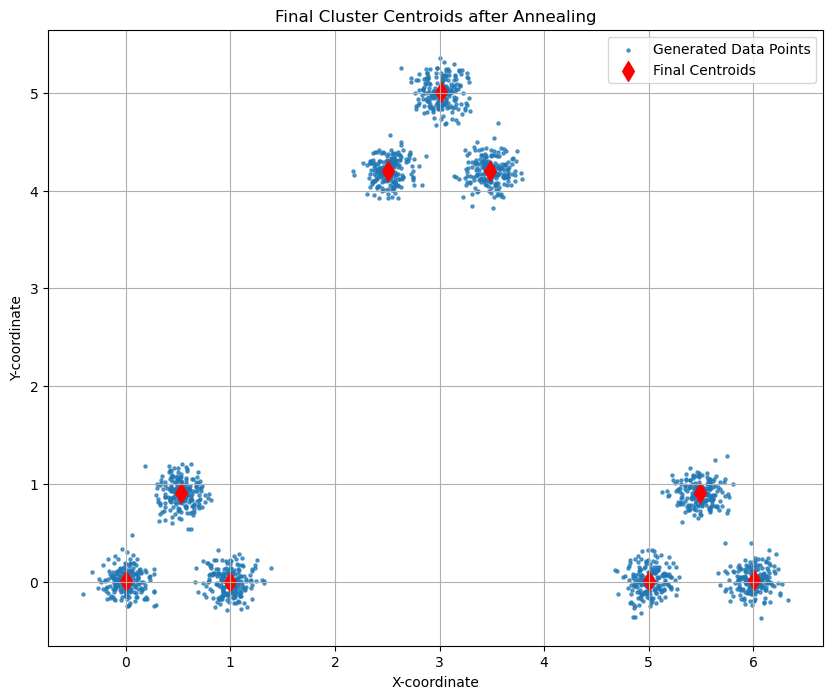

Clustering process completed.
Final Centroids:


In [3]:
np.random.seed(42)

def calculate_distortion(X, Y):
    """
    Calculates the squared Euclidean distance between each point in X and each centroid in Y.
    Args:
        X (np.ndarray): The data matrix of shape (M, N).
        Y (np.ndarray): The centroid matrix of shape (K, N).
    Returns:
        np.ndarray: A distance matrix of shape (M, K).
    """
    # X_sum_sq is a column vector of shape (M, 1)
    X_sum_sq = np.sum(X**2, axis=1, keepdims=True)
    
    # Y_sum_sq is a row vector of shape (1, K)
    Y_sum_sq = np.sum(Y**2, axis=1, keepdims=True).T
    
    # D is the squared Euclidean distance matrix using the formula:
    # ||x - y||^2 = ||x||^2 + ||y||^2 - 2 * x.T * y
    D = X_sum_sq + Y_sum_sq - 2 * X @ Y.T
    return D

# %% Constructing Data Set 6
# Define the centers of the nine clusters
C1 = np.array([0, 0])
C2 = np.array([1, 0])
C3 = np.array([0.5, 0.9])
C4 = np.array([5, 0])
C5 = np.array([6, 0])
C6 = np.array([5.5, 0.9])
C7 = np.array([2.5, 4.2])
C8 = np.array([3.5, 4.2])
C9 = np.array([3, 5])
Centers = np.array([C1, C2, C3, C4, C5, C6, C7, C8, C9])

# Number of points per cluster
Np = 200
num_clusters = len(Centers)
total_points = num_clusters * Np

# Standard deviation for generating data points
std_dev = 0.125

# Create the data matrix X
X = np.zeros((total_points, 2))
count = 0
for i in range(num_clusters):
    for _ in range(Np):
        x = np.random.normal(Centers[i, 0], std_dev)
        y = np.random.normal(Centers[i, 1], std_dev)
        X[count, :] = [x, y]
        count += 1

# Plot the initial generated data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.7, label='Generated Data Points')
plt.title('Initial Data Distribution')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)
plt.show()

# Get the dimensions of the data matrix
M, N = X.shape

# %% Setting for DA parameters
K = 9                       # Number of clusters
Tmin = 0.05                 # Minimum temperature
alpha = 0.99                # Annealing rate
PERTURB = 0.005             # Perturbation factor
STOP = 1e-5                 # Stopping criterion for inner loop
T = 80                      # Initial temperature

# Px is the weight for each data point, assuming uniform weights
Px = np.full((M, 1), 1 / M)

# Y is the matrix of cluster centroids, initialized to the weighted mean of the data.
# This corresponds to `Y = repmat(Px'*X, [K,1])` in MATLAB.
initial_mean = (Px.T @ X).reshape(1, -1)
Y = np.tile(initial_mean, (K, 1))

print('-------')
print(Px.T)
print(X)
print(initial_mean)
print('-------')
print(Y)

# Start the annealing process
while T >= Tmin:
    L_old = np.inf
    print('Temperature',T)
    while True:
        # Calculate distortion matrix D
        D = calculate_distortion(X, Y)

        # Calculate the probability matrix P using the softmax function
        # This replaces the `exp`, `sum`, and `repmat` operations from MATLAB
        D_bar = D - np.min(D, axis = 1, keepdims=True)
        num = np.exp(-D_bar / T)
        den = np.sum(num, axis=1, keepdims=True)
        P = num / den

        # Update the cluster centroids Y
        # This replaces `P'*(X.*repmat(Px,[1 N]))./repmat(Py,[1 N])`
        Py = P.T @ Px
        Py[Py == 0] = 1e-10  # Avoid division by zero
        Y = (P.T @ (X * Px)) / Py.reshape(-1, 1)

        unique_rows = np.unique(Y, axis=0)
        number_of_unique_rows = unique_rows.shape[0]
        # print("Unique rows:\n", unique_rows)
        # print("Number of unique rows:", unique_rows.shape[0])

        # Add a small random perturbation to the centroids
        Y += PERTURB * np.random.rand(*Y.shape)
        
        # Calculate the loss function L
        L = -T * Px.T @ np.log(np.sum(np.exp(-D / T), axis=1, keepdims=True))

        print('Loss',L)

        # Check for convergence
        if np.linalg.norm(L - L_old) < STOP:
            break

        # Update L_old for the next iteration
        L_old = L

        # print(np.linalg.norm(L - L_old))
        # print(Y)

    # Decrease the temperature for the next outer loop iteration
    T *= alpha

# Plot the final result
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.7, label='Generated Data Points')
plt.scatter(Y[:, 0], Y[:, 1], marker='d', s=100, color='red', label='Final Centroids')
plt.title('Final Cluster Centroids after Annealing')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()

print("Clustering process completed.")
print("Final Centroids:")
# print(X)
# print(Y)

# DA for graph aggregation

In [4]:
def calculate_distortion(X, Y):
    """
    Calculates the squared Euclidean distance between each point in X and each centroid in Y.
    Args:
        X (np.ndarray): The data matrix of shape (M, N).
        Y (np.ndarray): The centroid matrix of shape (K, N).
    Returns:
        np.ndarray: A distance matrix of shape (M, K).
    """
    # X_sum_sq is a column vector of shape (M, 1)
    X_sum_sq = np.sum(X**2, axis=1, keepdims=True)
    
    # Y_sum_sq is a row vector of shape (1, K)
    Y_sum_sq = np.sum(Y**2, axis=1, keepdims=True).T
    
    # D is the squared Euclidean distance matrix using the formula:
    # ||x - y||^2 = ||x||^2 + ||y||^2 - 2 * x.T * y
    D = X_sum_sq + Y_sum_sq - 2 * X @ Y.T
    return D

## random graph generation

In [5]:
def generate_directed_graph_with_weights(num_nodes, edge_prob=0.4, weight_range=(1, 10), seed=None):
    """
    Generates a directed graph with random edge weights.
    Args:
        num_nodes (int): Number of nodes in the graph.
        edge_prob (float): Probability of edge creation between nodes.
        weight_range (tuple): Range (min, max) for random edge weights.
        seed (int): Random seed for reproducibility.
    Returns:
        G (nx.DiGraph): A directed graph with weighted edges.
    """
    G = nx.gnp_random_graph(num_nodes, edge_prob, directed=True, seed=seed)
    for (u, v) in G.edges():
        G[u][v]['weight'] = random.randint(*weight_range)
    return G

## da algorithm for graph aggregation

In [6]:
def DA_algo_graph(G, K):
    np.random.seed(42)
    random.seed(42)

    num_nodes = G.number_of_nodes()
    edge_labels = nx.get_edge_attributes(G, 'weight')

    X = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            try:
                X[i,j] = edge_labels[(i,j)]
            except:
                pass

    #Get the dimensions of the data matrix
    M, N = X.shape

    # %% Setting for DA parameters
    # K = 3                     # Number of clusters
    Tmin = 0.01                 # Minimum temperature
    alpha = 0.99                # Annealing rate
    PERTURB = 0.0005            # Perturbation factor
    STOP = 1e-5                 # Stopping criterion for inner loop
    T = 80                      # Initial temperature

    # Px is the weight for each data point, assuming uniform weights
    Px = np.full((M, 1), 1 / M)

    # Y is the matrix of cluster centroids, initialized to the weighted mean of the data.
    initial_mean = (Px.T @ X).reshape(1, -1)

    print(Px.T)
    print(X)
    print(initial_mean)

    Y = np.tile(initial_mean, (K, 1))

    print('X:',X)
    print('Y:',Y)

    # Start the annealing process
    while T >= Tmin:
        L_old = np.inf
        while True:
            # Calculate distortion matrix D
            D = calculate_distortion(X, Y)

            # Calculate the probability matrix P using the softmax function
            D_bar = D - np.min(D, axis=1, keepdims=True)
            num = np.exp(-D_bar / T)
            den = np.sum(num, axis=1, keepdims=True)
            P = num / den

            # Update the cluster centroids Y
            Py = P.T @ Px
            Py[Py == 0] = 1e-10  # Avoid division by zero
            Y = (P.T @ (X * Px)) / Py.reshape(-1, 1)

            # Add a small random perturbation to the centroids
            Y += PERTURB * np.random.rand(*Y.shape)
            
            # Calculate the loss function L
            L = -T * Px.T @ np.log(np.sum(np.exp(-D_bar / T), axis=1, keepdims=True))

            # Check for convergence
            if np.linalg.norm(L - L_old) < STOP:
                break

            # if L == [np.inf]:
            #     break

            # Update L_old for the next iteration
            L_old = L

        # Decrease the temperature for the next outer loop iteration
        T *= alpha

    print('final probabilities P:',P)
    print('final centroid Y:',Y)

    supernodes_matrix = Y@P

    G_supernode = nx.from_numpy_array(supernodes_matrix, create_using=nx.DiGraph)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_supernode)
    nx.draw(G_supernode, pos, with_labels=True, node_color='lightgreen', arrowsize=20, arrowstyle='-|>')
    edge_labels = nx.get_edge_attributes(G_supernode, 'weight')
    nx.draw_networkx_edge_labels(G_supernode, pos, edge_labels=edge_labels)
    plt.title('Composite Graph')
    plt.show()

## customized graph

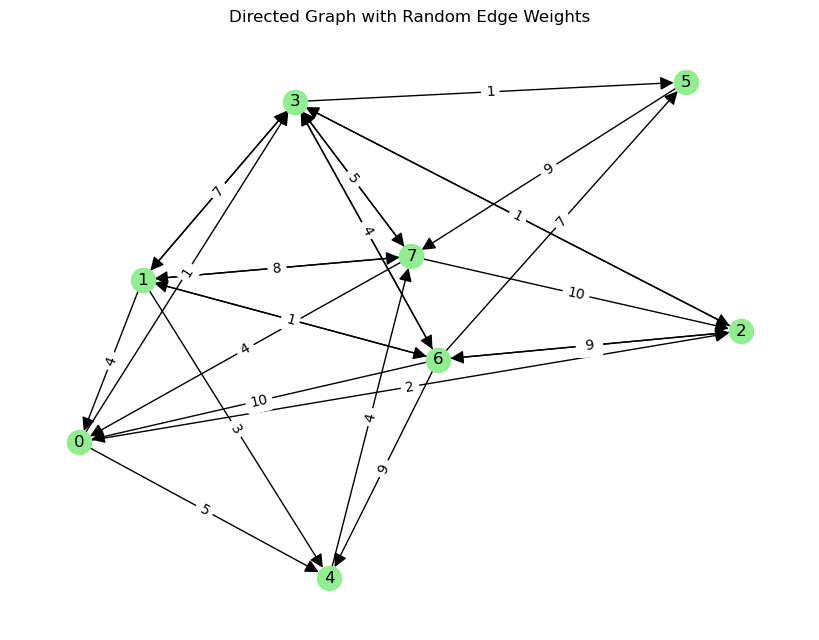

{(0, 2): 2, (0, 3): 1, (0, 4): 5, (1, 0): 4, (1, 3): 4, (1, 4): 3, (1, 6): 2, (1, 7): 9, (2, 3): 2, (2, 6): 10, (3, 1): 7, (3, 2): 1, (3, 5): 1, (3, 6): 2, (3, 7): 4, (4, 7): 4, (5, 7): 9, (6, 0): 10, (6, 1): 1, (6, 2): 9, (6, 3): 4, (6, 4): 9, (6, 5): 7, (7, 0): 4, (7, 1): 8, (7, 2): 10, (7, 3): 5}
[[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]]
[[ 0.  0.  2.  1.  5.  0.  0.  0.]
 [ 4.  0.  0.  4.  3.  0.  2.  9.]
 [ 0.  0.  0.  2.  0.  0. 10.  0.]
 [ 0.  7.  1.  0.  0.  1.  2.  4.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.]
 [ 0.  0.  0.  0.  0.  0.  0.  9.]
 [10.  1.  9.  4.  9.  7.  0.  0.]
 [ 4.  8. 10.  5.  0.  0.  0.  0.]]
[[2.25  2.    2.75  2.    2.125 1.    1.75  3.25 ]]
X: [[ 0.  0.  2.  1.  5.  0.  0.  0.]
 [ 4.  0.  0.  4.  3.  0.  2.  9.]
 [ 0.  0.  0.  2.  0.  0. 10.  0.]
 [ 0.  7.  1.  0.  0.  1.  2.  4.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.]
 [ 0.  0.  0.  0.  0.  0.  0.  9.]
 [10.  1.  9.  4.  9.  7.  0.  0.]
 [ 4.  8. 10.  5.  0.  0.  0.  0.]]
Y: [[2.25  2.    2.75  2.    2

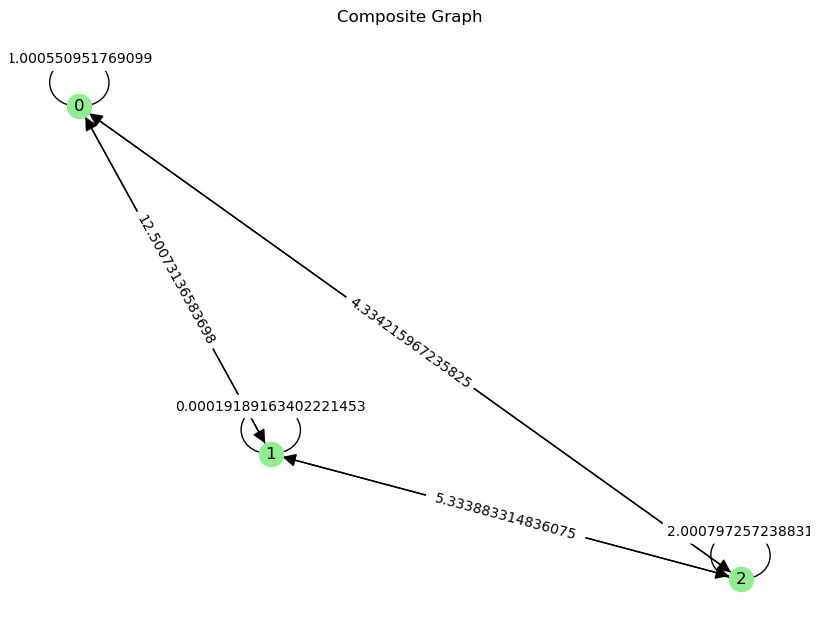

In [7]:
np.random.seed(42)
random.seed(42)

num_nodes = 8
edge_prob = 0.4
weight_range = (1, 10)
seed = 42
G = generate_directed_graph_with_weights(num_nodes, edge_prob, weight_range, seed=seed)

# Draw the graph with edge weights
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', arrowsize=20, arrowstyle='-|>')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Directed Graph with Random Edge Weights')
plt.show()

print(edge_labels)

DA_algo_graph(G, 3)

## karate club graph

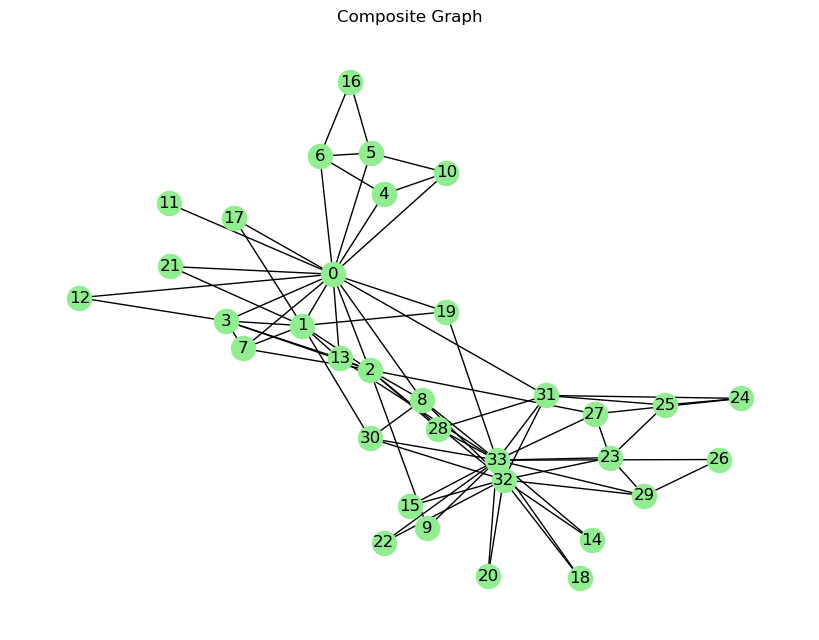

{(0, 1): 4, (0, 2): 5, (0, 3): 3, (0, 4): 3, (0, 5): 3, (0, 6): 3, (0, 7): 2, (0, 8): 2, (0, 10): 2, (0, 11): 3, (0, 12): 1, (0, 13): 3, (0, 17): 2, (0, 19): 2, (0, 21): 2, (0, 31): 2, (1, 2): 6, (1, 3): 3, (1, 7): 4, (1, 13): 5, (1, 17): 1, (1, 19): 2, (1, 21): 2, (1, 30): 2, (2, 3): 3, (2, 7): 4, (2, 8): 5, (2, 9): 1, (2, 13): 3, (2, 27): 2, (2, 28): 2, (2, 32): 2, (3, 7): 3, (3, 12): 3, (3, 13): 3, (4, 6): 2, (4, 10): 3, (5, 6): 5, (5, 10): 3, (5, 16): 3, (6, 16): 3, (8, 30): 3, (8, 32): 3, (8, 33): 4, (9, 33): 2, (13, 33): 3, (14, 32): 3, (14, 33): 2, (15, 32): 3, (15, 33): 4, (18, 32): 1, (18, 33): 2, (19, 33): 1, (20, 32): 3, (20, 33): 1, (22, 32): 2, (22, 33): 3, (23, 25): 5, (23, 27): 4, (23, 29): 3, (23, 32): 5, (23, 33): 4, (24, 25): 2, (24, 27): 3, (24, 31): 2, (25, 31): 7, (26, 29): 4, (26, 33): 2, (27, 33): 4, (28, 31): 2, (28, 33): 2, (29, 32): 4, (29, 33): 2, (30, 32): 3, (30, 33): 3, (31, 32): 4, (31, 33): 4, (32, 33): 5}
[[0.02941176 0.02941176 0.02941176 0.02941176 0.

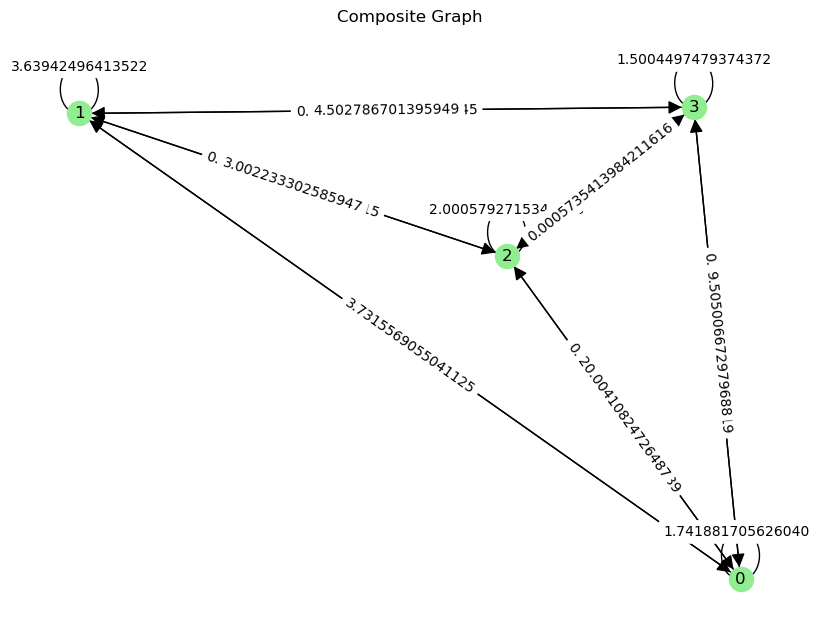

In [8]:
np.random.seed(42)
random.seed(42)

G = nx.karate_club_graph()
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', arrowsize=20, arrowstyle='-|>')
edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Composite Graph')
plt.show()

print(edge_labels)
DA_algo_graph(G, 4)

# np.random.seed(42)
# coms = algorithms.louvain(G, weight='weight', resolution=1., randomize=False)

# # Get community membership for each node
# membership = {}
# for i, community in enumerate(coms.communities):
#     for node in community:
#         membership[node] = i

# # Assign a color to each node based on its community
# node_colors = [membership[node] for node in G.nodes()]

# plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Set3, arrowsize=20, arrowstyle='-|>')
# plt.title('Communities in Graph')
# plt.show()

# dict(sorted(membership.items()))
# edge_labels